In [58]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement scypy (from versions: none)
ERROR: No matching distribution found for scypy


# Data Understanding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('hotel_booking.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nBasic Information:")
print(df.info())
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum().sort_values(ascending=False))
# Check for duplicates
df.duplicated().sum()
print("\nFirst few rows:")
print(df.head())

Dataset Shape: (119390, 36)

Columns: ['hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status', 'reservation_status_date', 'name', 'email', 'phone-number', 'credit_card']

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119

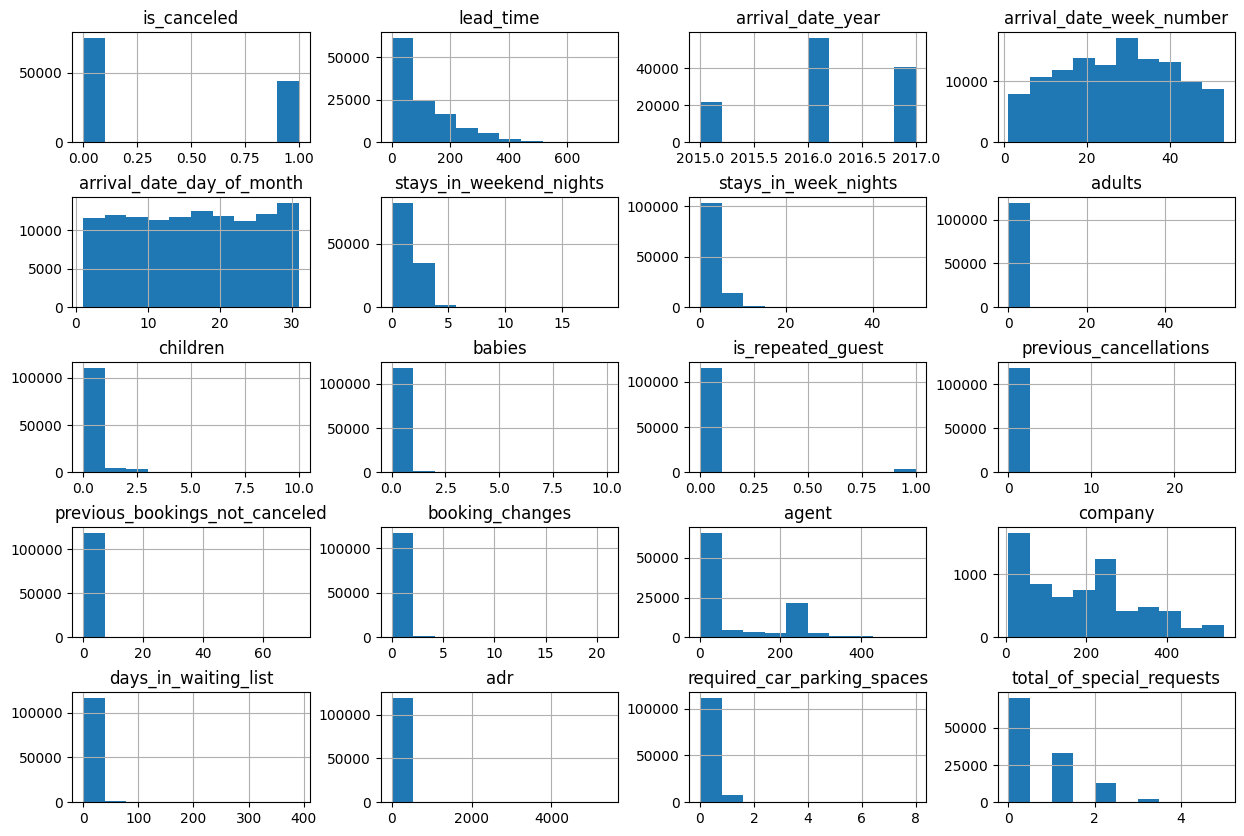

In [2]:
# Plot the duistribution of the numerical features
df.hist(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)
plt.show()

In [3]:
# Remove sensitive information
columns_to_drop = ['name', 'email', 'phone-number', 'credit_card']
df = df.drop(columns=columns_to_drop)

In [4]:
# Select categorical features
categorical_features = df.select_dtypes(include='object').columns.tolist()
categorical_features

['hotel',
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status',
 'reservation_status_date']

In [5]:
# Remove reservation_status_date and country
categorical_features.remove('reservation_status_date')
categorical_features.remove('country')

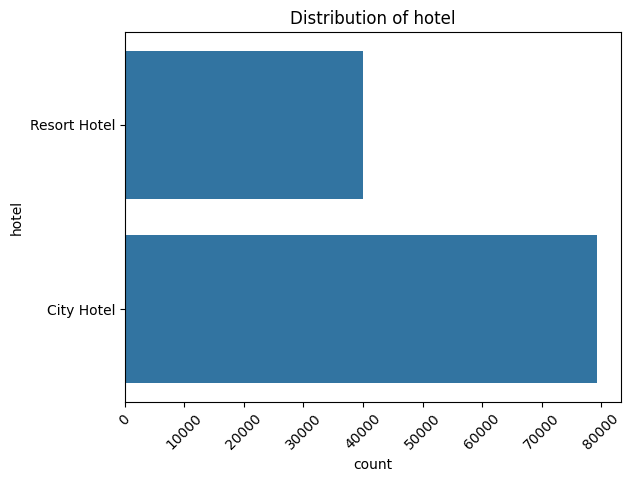

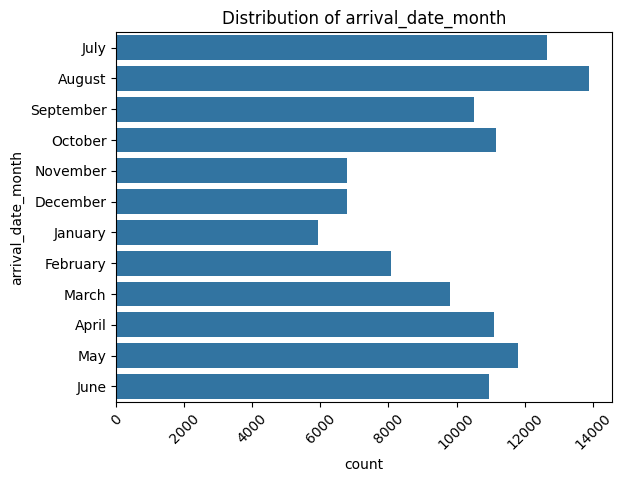

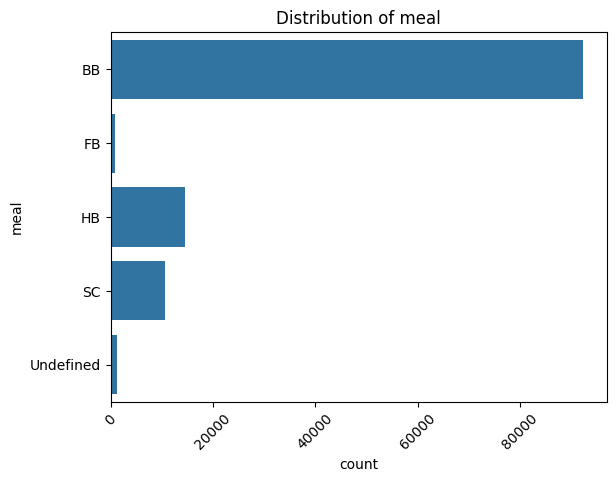

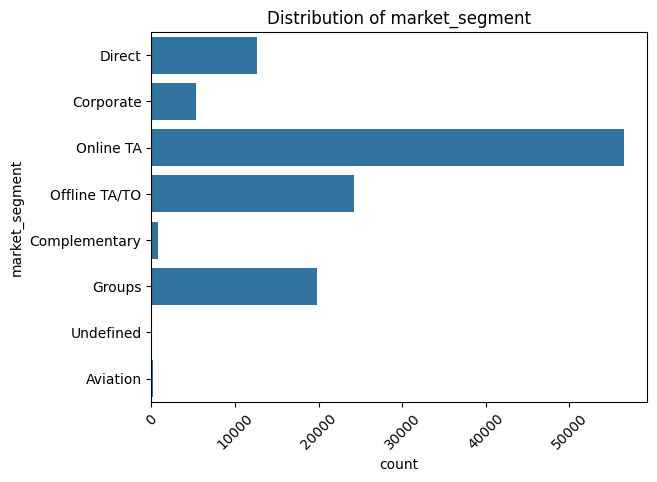

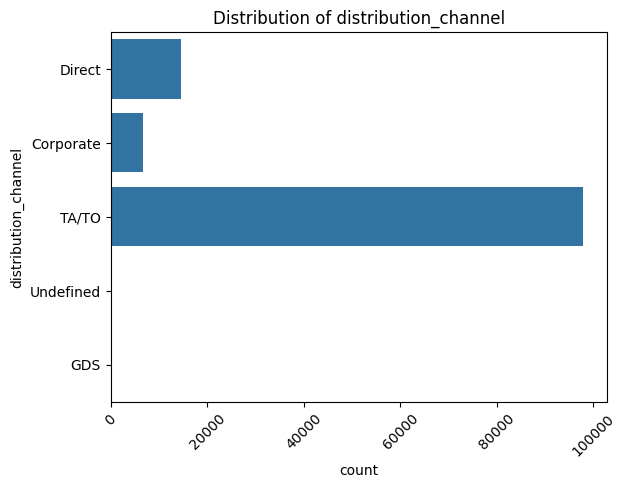

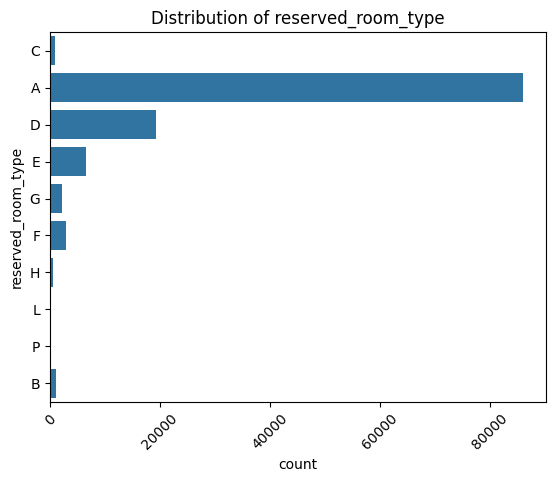

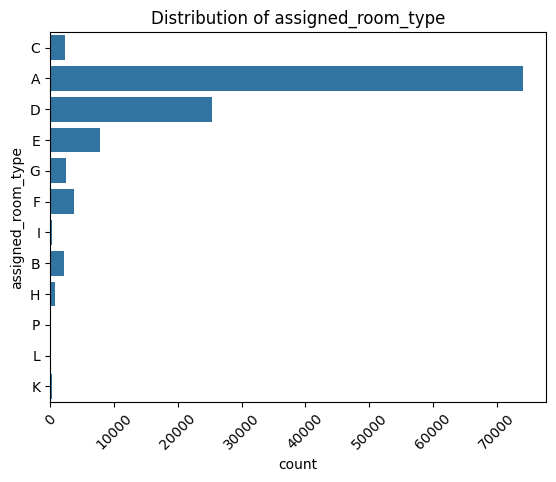

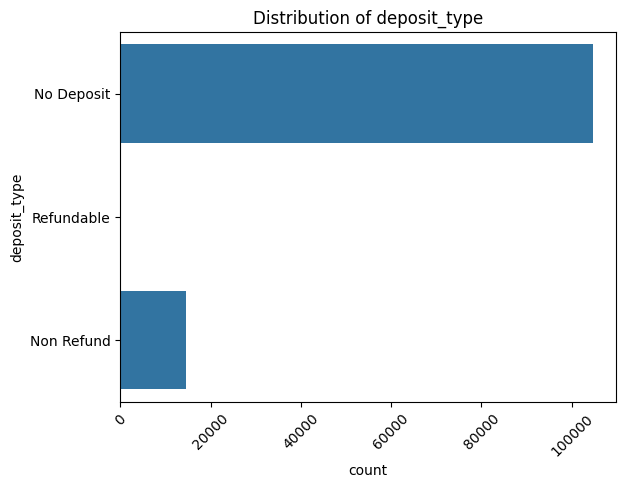

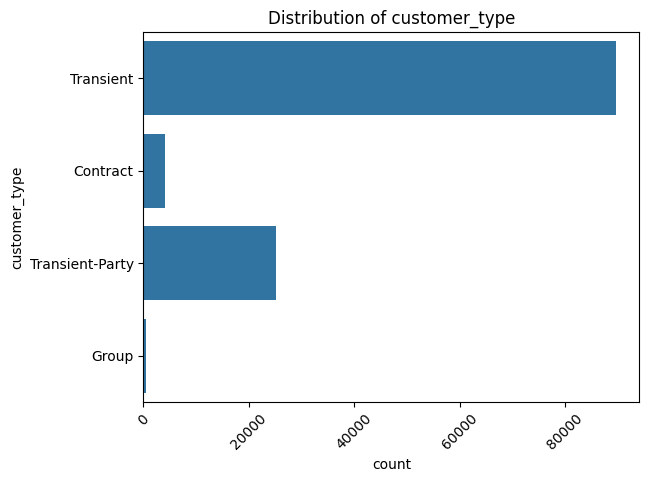

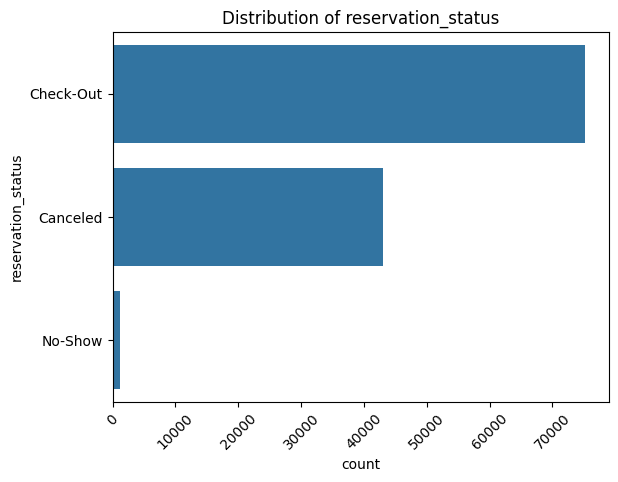

In [6]:
# Plot the distribution of the categorical features
for feature in categorical_features:
    sns.countplot(df[feature])
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
    plt.show()

Overall cancellation rate: 37.04%


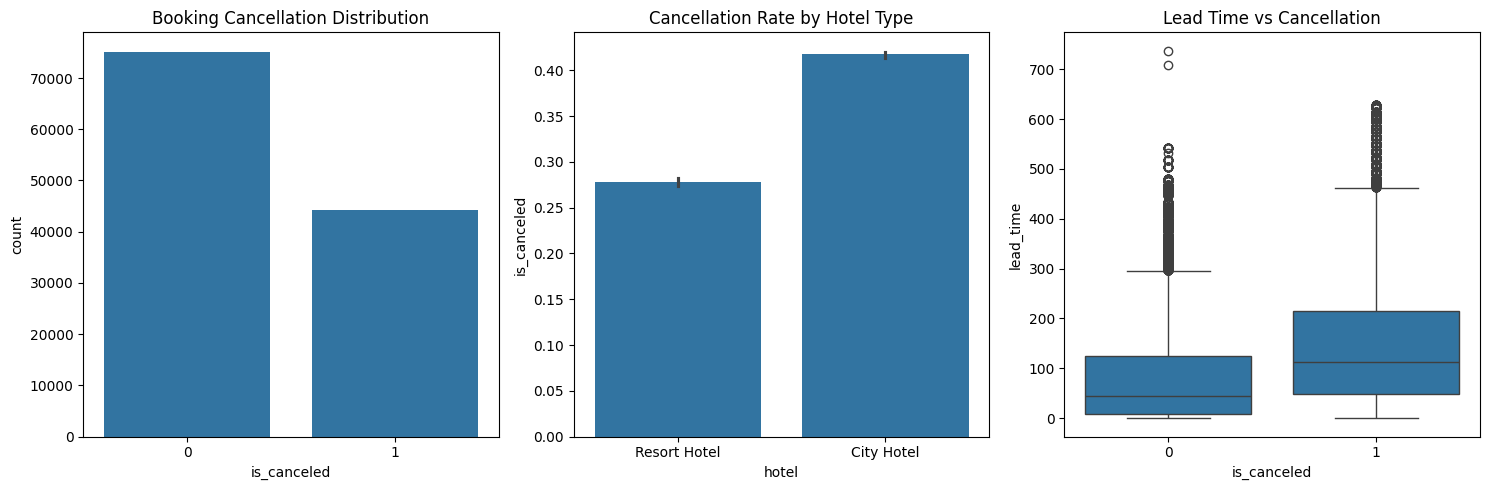


Cancellation rates by market segment:
market_segment
Undefined        1.000000
Groups           0.610620
Online TA        0.367211
Offline TA/TO    0.343160
Aviation         0.219409
Corporate        0.187347
Direct           0.153419
Complementary    0.130552
Name: is_canceled, dtype: float64

Average lead time for cancelled vs non-cancelled bookings:
is_canceled
0     79.984687
1    144.848815
Name: lead_time, dtype: float64


In [7]:
# Basic statistics about cancellations
cancellation_rate = df['is_canceled'].mean() * 100
print(f"Overall cancellation rate: {cancellation_rate:.2f}%")

# Create some initial visualizations
plt.figure(figsize=(15, 5))

# Plot 1: Cancellation distribution
plt.subplot(131)
sns.countplot(data=df, x='is_canceled')
plt.title('Booking Cancellation Distribution')

# Plot 2: Cancellation rate by hotel type
plt.subplot(132)
sns.barplot(data=df, x='hotel', y='is_canceled')
plt.title('Cancellation Rate by Hotel Type')

# Plot 3: Lead time distribution by cancellation status
plt.subplot(133)
sns.boxplot(data=df, x='is_canceled', y='lead_time')
plt.title('Lead Time vs Cancellation')

plt.tight_layout()
plt.show()

# Additional insights
print("\nCancellation rates by market segment:")
print(df.groupby('market_segment')['is_canceled'].mean().sort_values(ascending=False))

print("\nAverage lead time for cancelled vs non-cancelled bookings:")
print(df.groupby('is_canceled')['lead_time'].mean())


Cancellation rate by deposit type:
deposit_type
Non Refund    0.993624
No Deposit    0.283770
Refundable    0.222222
Name: is_canceled, dtype: float64

Cancellation rate by customer type:
customer_type
Transient          0.407463
Contract           0.309617
Transient-Party    0.254299
Group              0.102253
Name: is_canceled, dtype: float64


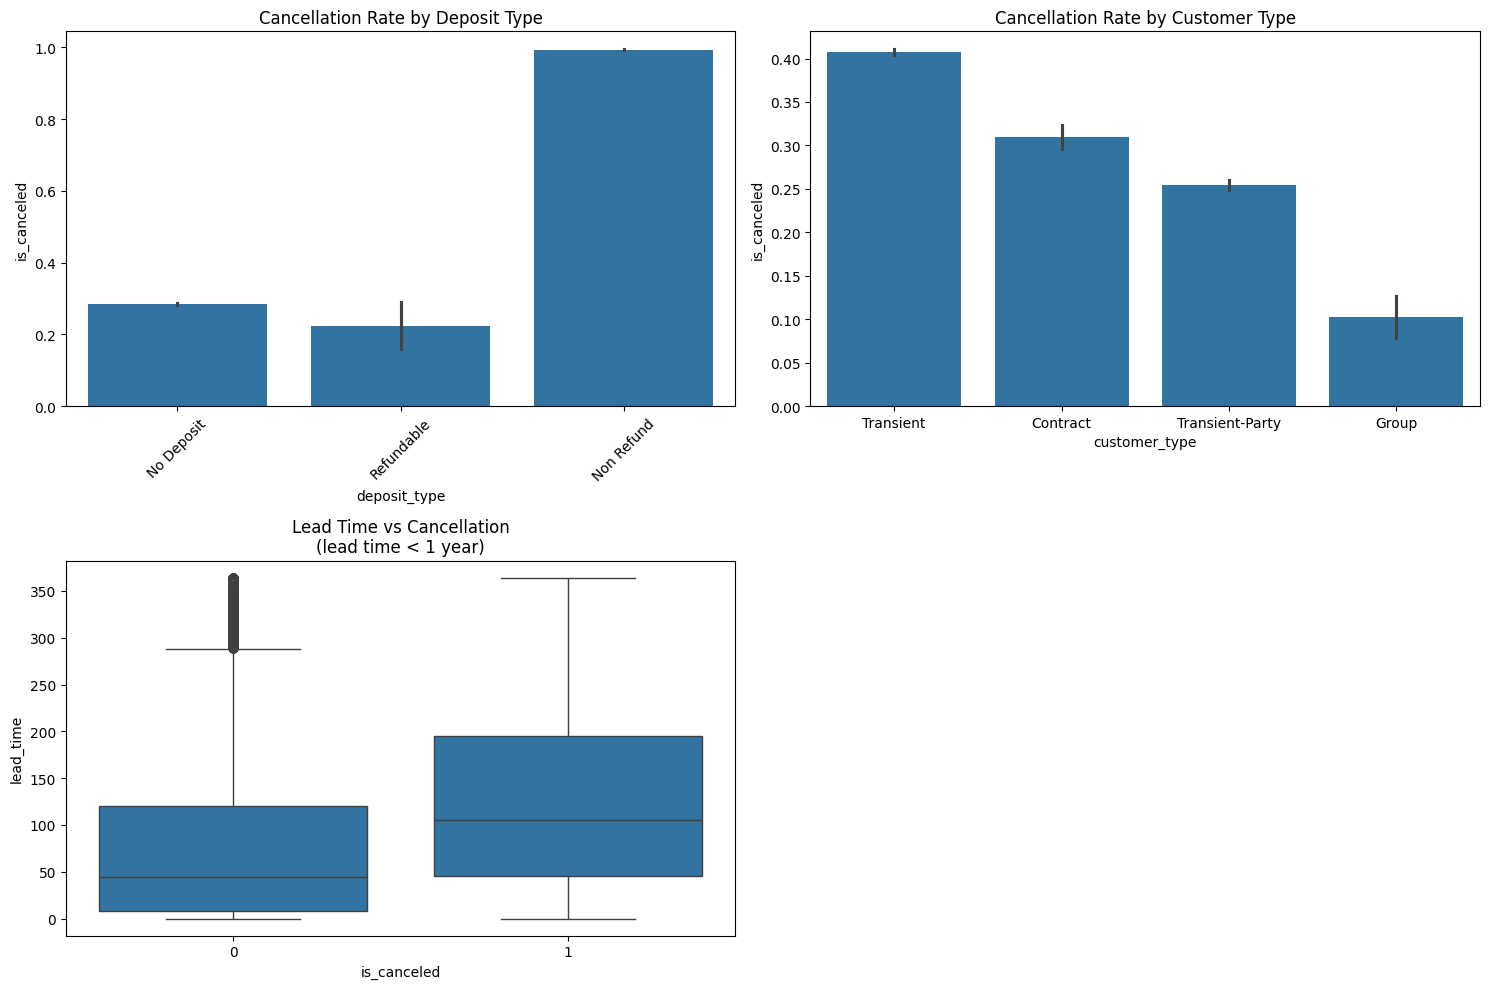

In [8]:
# Print deposit type and customer type statistics
print("\nCancellation rate by deposit type:")
print(df.groupby('deposit_type')['is_canceled'].mean().sort_values(ascending=False))

print("\nCancellation rate by customer type:")
print(df.groupby('customer_type')['is_canceled'].mean().sort_values(ascending=False))

# Visualizations
plt.figure(figsize=(15, 10))

# Plot 1: Cancellation rate by deposit type
plt.subplot(221)
sns.barplot(data=df, x='deposit_type', y='is_canceled')
plt.title('Cancellation Rate by Deposit Type')
plt.xticks(rotation=45)

# Plot 2: Cancellation rate by customer type
plt.subplot(222)
sns.barplot(data=df, x='customer_type', y='is_canceled')
plt.title('Cancellation Rate by Customer Type')

# Plot 3: Lead time distribution by cancellation
plt.subplot(223)
sns.boxplot(data=df[df['lead_time'] < 365], x='is_canceled', y='lead_time')
plt.title('Lead Time vs Cancellation\n(lead time < 1 year)')

plt.tight_layout()
plt.show()

# Data Preparation

## Outlier Removal

In [9]:
# Function to count outliers in numerical columns.
def count_outliers(df):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for column in num_cols:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        print(f'Number of outliers in {column}: {outliers.shape[0]}')

# removing outliers on numerical columns
def remove_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[column] > lower_bound) & (df[column] < upper_bound)]

numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
numerical_columns = numerical_columns.drop(['is_canceled', 'agent', 'company', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations',
                                            'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces'])

print(numerical_columns)



Index(['lead_time', 'arrival_date_year', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adr', 'total_of_special_requests'],
      dtype='object')


In [10]:
count_outliers(df)

Number of outliers in is_canceled: 0
Number of outliers in lead_time: 3005
Number of outliers in arrival_date_year: 0
Number of outliers in arrival_date_week_number: 0
Number of outliers in arrival_date_day_of_month: 0
Number of outliers in stays_in_weekend_nights: 265
Number of outliers in stays_in_week_nights: 3354
Number of outliers in adults: 29710
Number of outliers in children: 8590
Number of outliers in babies: 917
Number of outliers in is_repeated_guest: 3810
Number of outliers in previous_cancellations: 6484
Number of outliers in previous_bookings_not_canceled: 3620
Number of outliers in booking_changes: 18076
Number of outliers in agent: 0
Number of outliers in company: 0
Number of outliers in days_in_waiting_list: 3698
Number of outliers in adr: 3793
Number of outliers in required_car_parking_spaces: 7416
Number of outliers in total_of_special_requests: 2877


In [11]:
# adults - days_in_waiting_list, required_car_parking_spaces
for column in numerical_columns:
    df = remove_outliers(df, column)

count_outliers(df)
print(len(df))


Number of outliers in is_canceled: 0
Number of outliers in lead_time: 637
Number of outliers in arrival_date_year: 0
Number of outliers in arrival_date_week_number: 0
Number of outliers in arrival_date_day_of_month: 0
Number of outliers in stays_in_weekend_nights: 0
Number of outliers in stays_in_week_nights: 0
Number of outliers in adults: 27044
Number of outliers in children: 6103
Number of outliers in babies: 669
Number of outliers in is_repeated_guest: 3532
Number of outliers in previous_cancellations: 6061
Number of outliers in previous_bookings_not_canceled: 3317
Number of outliers in booking_changes: 15228
Number of outliers in agent: 653
Number of outliers in company: 0
Number of outliers in days_in_waiting_list: 3475
Number of outliers in adr: 975
Number of outliers in required_car_parking_spaces: 6341
Number of outliers in total_of_special_requests: 0
105305


## Feature Engineering and Reduction

In [12]:
# Create feature engineering pipeline
def engineer_features(df):
    # Create copy to avoid modifying original
    df_proc = df.copy()
    
    # Temporal features
    df_proc['arrival_date'] = pd.to_datetime(df_proc['arrival_date_year'].astype(str) + '-' + 
                                           df_proc['arrival_date_month'] + '-' + 
                                           df_proc['arrival_date_day_of_month'].astype(str))
    df_proc['booking_date'] = df_proc['arrival_date'] - pd.to_timedelta(df_proc['lead_time'], unit='D')
    df_proc['is_weekend_arrival'] = df_proc['arrival_date'].dt.dayofweek >= 5
    
    # Aggregate features
    df_proc['total_nights'] = df_proc['stays_in_weekend_nights'] + df_proc['stays_in_week_nights']
    df_proc['total_guests'] = df_proc['adults'] + df_proc['children'].fillna(0) + df_proc['babies']
    
    # Room type match
    df_proc['got_desired_room'] = (df_proc['reserved_room_type'] == df_proc['assigned_room_type']).astype(int)
    
    # Season feature
    conditions = [
        df_proc['arrival_date_month'].isin(['December', 'January', 'February']),
        df_proc['arrival_date_month'].isin(['March', 'April', 'May']),
        df_proc['arrival_date_month'].isin(['June', 'July', 'August']),
        df_proc['arrival_date_month'].isin(['September', 'October', 'November'])
    ]
    choices = ['winter', 'spring', 'summer', 'fall']
    df_proc['season'] = np.select(conditions, choices, default='unknown')
    
    # Drop unnecessary columns
    cols_to_drop = ['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month',
                    'arrival_date_week_number', 'arrival_date', 'reservation_status', 
                    'reservation_status_date']
    
    return df_proc.drop(columns=cols_to_drop)

# Handle missing values
def handle_missing_values(df):
    df_clean = df.copy()
    
    # Fill missing values
    df_clean['children'] = df_clean['children'].fillna(0)
    df_clean['country'] = df_clean['country'].fillna('Unknown')
    df_clean['agent'] = df_clean['agent'].fillna(0)
    df_clean['company'] = df_clean['company'].fillna(0)
    
    return df_clean

# Run preprocessing
print("Starting preprocessing...")
df_processed = engineer_features(df)
df_processed = handle_missing_values(df_processed)

# Show resulting features
print("\nProcessed features:")
print(df_processed.columns.tolist())

# Show sample of engineered features
print("\nSample of engineered features:")
print(df_processed[['booking_date', 'is_weekend_arrival', 'total_nights', 
                   'total_guests', 'got_desired_room', 'season']].head())

Starting preprocessing...

Processed features:
['hotel', 'is_canceled', 'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'booking_date', 'is_weekend_arrival', 'total_nights', 'total_guests', 'got_desired_room', 'season']

Sample of engineered features:
  booking_date  is_weekend_arrival  total_nights  total_guests  \
0   2014-07-24               False             0           2.0   
2   2015-06-24               False             1           1.0   
3   2015-06-18               False             1           1.0   
4   2015-06-17               False             2           2.0   
5   2015-06-17       

In [13]:
# Check if variables that are not supposed to have zero values have zero values
print("Number of rows where total_guests is 0:", (df_processed['total_guests'] == 0).sum())
print("Number of rows where total_nights is 0:", (df_processed['total_nights'] == 0).sum())

Number of rows where total_guests is 0: 147
Number of rows where total_nights is 0: 701


In [14]:
# Calculate correlations correctly
numerical_cols = ['lead_time', 'total_nights', 'total_guests', 'adr', 
                 'required_car_parking_spaces', 'total_of_special_requests',
                 'previous_cancellations', 'previous_bookings_not_canceled']

correlations = {col: df_processed['is_canceled'].corr(df_processed[col]) for col in numerical_cols}
print("\nCorrelations with cancellation:")
for col, corr in sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"{col}: {corr:.3f}")


Correlations with cancellation:
lead_time: 0.304
total_of_special_requests: -0.229
required_car_parking_spaces: -0.191
previous_cancellations: 0.114
adr: 0.077
previous_bookings_not_canceled: -0.058
total_guests: 0.053
total_nights: 0.036


Text(0.5, 1.0, 'Length of Stay vs Cancellation\n(stays < 15 nights)')

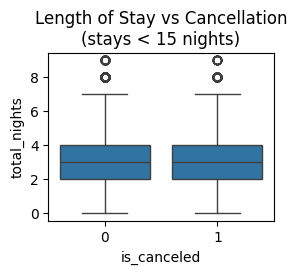

In [15]:
# Plot 3: Total nights distribution for cancelled vs non-cancelled
plt.subplot(223)
sns.boxplot(data=df_processed[df_processed['total_nights'] < 15], x='is_canceled', y='total_nights')
plt.title('Length of Stay vs Cancellation\n(stays < 15 nights)')

is_canceled      0      1  total  cancellation_rate
season                                             
fall         16306   9275  25581           0.362574
spring       18879  11251  30130           0.373415
summer       18378  11925  30303           0.393525
winter       13137   6154  19291           0.319009


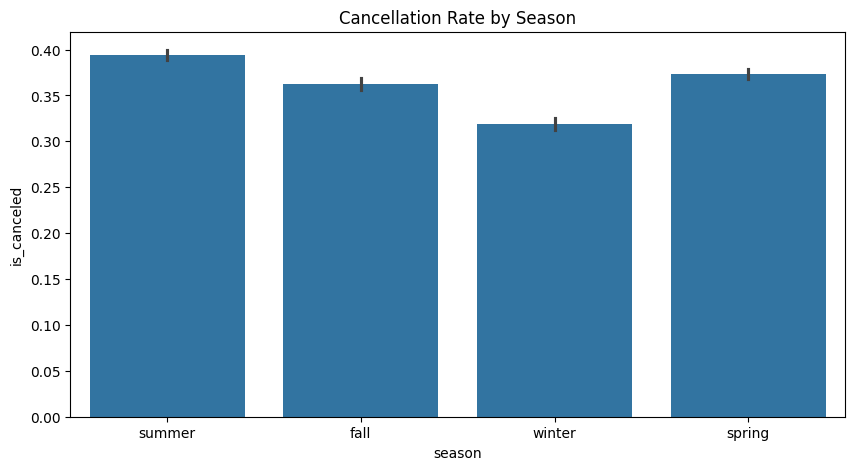

In [16]:
# Check cancellation rate of bookings by season
df_season = df_processed.groupby(['season', 'is_canceled']).size().unstack()
df_season['total'] = df_season.sum(axis=1)
df_season['cancellation_rate'] = df_season[1] / df_season['total']
print(df_season)

plt.figure(figsize=(10, 5))
sns.barplot(data=df_processed, x='season', y='is_canceled')
plt.title('Cancellation Rate by Season')
plt.show()

## Feature Selection

Since our target variable, even though numerical, is categorical, the following feature selection algorithms will be performed:
- Chi: to analyse the correlation of the target and the categorical features;
- ANOVA: to analyse the correlation of the target and the continuous features; 
- Lasso

### Chi

In [17]:
categorical_cols = df_processed.select_dtypes(include=['object', 'bool']).columns.tolist()
categorical_cols

['hotel',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'is_weekend_arrival',
 'season']

In [18]:
def FunctionChisq(inpData, TargetVariable, CategoricalVariablesList):
    from scipy.stats import chi2_contingency
    
    # Creating an empty list of final selected predictors
    SelectedPredictors=[]

    for predictor in CategoricalVariablesList:
        CrossTabResult=pd.crosstab(index=inpData[TargetVariable], columns=inpData[predictor])
        ChiSqResult = chi2_contingency(CrossTabResult)
        
        # If the ChiSq P-Value is <0.05, that means we reject H0
        if (ChiSqResult[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', ChiSqResult[1])
            SelectedPredictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', ChiSqResult[1])        
            
    return(SelectedPredictors)

In [19]:
FunctionChisq(inpData=df_processed, TargetVariable='is_canceled', CategoricalVariablesList=categorical_cols)

hotel is correlated with is_canceled | P-Value: 0.0
meal is correlated with is_canceled | P-Value: 1.4569353892756737e-66
country is correlated with is_canceled | P-Value: 0.0
market_segment is correlated with is_canceled | P-Value: 0.0
distribution_channel is correlated with is_canceled | P-Value: 0.0
reserved_room_type is correlated with is_canceled | P-Value: 2.3628281930819817e-101
assigned_room_type is correlated with is_canceled | P-Value: 0.0
deposit_type is correlated with is_canceled | P-Value: 0.0
customer_type is correlated with is_canceled | P-Value: 0.0
is_weekend_arrival is NOT correlated with is_canceled | P-Value: 0.3680108299043874
season is correlated with is_canceled | P-Value: 1.0839868190517814e-62


['hotel',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'season']

According to Chi, all of the categorical features are correlated to the target. Here are the categorical features sorted from highest P-value to lowest:
- is_weekend_arrival;
- season;
- meal;
- reserved_room_type;
- distribution_channel (after this point all the features had P-value 0 so they are not in any particular order);
- market_segment;
- hotel;
- country;
- assigned_room_type;
- deposit_type;
- customer_type.


### ANOVA

In [20]:

def FunctionAnova(inpData, TargetVariable, ContinuousPredictorList):
    from scipy.stats import f_oneway

    # Creating an empty list of final selected predictors
    SelectedPredictors=[]
    
    print('##### ANOVA Results ##### \n')
    for predictor in ContinuousPredictorList:
        CategoryGroupLists=inpData.groupby(TargetVariable)[predictor].apply(list)
        AnovaResults = f_oneway(*CategoryGroupLists)
        
        # If the ANOVA P-Value is <0.05, that means we reject H0
        if (AnovaResults[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
            SelectedPredictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
    
    return(SelectedPredictors)

In [21]:
# Select numerical columns
numerical_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('is_canceled')
numerical_cols

['lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'company',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'total_nights',
 'total_guests']

In [22]:
FunctionAnova(inpData=df_processed, TargetVariable='is_canceled', ContinuousPredictorList=numerical_cols)

##### ANOVA Results ##### 

lead_time is correlated with is_canceled | P-Value: 0.0
stays_in_weekend_nights is correlated with is_canceled | P-Value: 0.01657354565869004
stays_in_week_nights is correlated with is_canceled | P-Value: 4.479154997712977e-40
adults is correlated with is_canceled | P-Value: 8.04838243305394e-103
children is NOT correlated with is_canceled | P-Value: 0.6858101472089937
babies is correlated with is_canceled | P-Value: 6.9525226439468015e-22
is_repeated_guest is correlated with is_canceled | P-Value: 3.3832223881657163e-165
previous_cancellations is correlated with is_canceled | P-Value: 8.927085376662705e-304
previous_bookings_not_canceled is correlated with is_canceled | P-Value: 1.8048092477332036e-78
booking_changes is correlated with is_canceled | P-Value: 0.0
agent is correlated with is_canceled | P-Value: 7.180355308729423e-67
company is correlated with is_canceled | P-Value: 1.9768092876710305e-163
days_in_waiting_list is correlated with is_canceled | 

['lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'company',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'total_nights',
 'total_guests']

According to ANOVA, 'children' and 'stays_in_weekend_nights' are not correlated to the target variable.

### Lasso

In [23]:
# Select binary features
binary_feaures = df_processed.nunique()[df_processed.nunique() == 2].keys().tolist()
binary_feaures

['hotel',
 'is_canceled',
 'is_repeated_guest',
 'is_weekend_arrival',
 'got_desired_room']

Only the 'hotel' feature is categorical so this is the only one that needs the Binary Encoding

In [24]:
# Replace hotel with 0 and 1
df_processed['hotel'] = df_processed['hotel'].map({'Resort Hotel': 0, 'City Hotel': 1})

In [25]:
df_processed_encoded = pd.get_dummies(df_processed, drop_first=True)
df_processed_encoded.head()

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,...,assigned_room_type_L,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,season_spring,season_summer,season_winter
0,0,0,342,0,0,2,0.0,0,0,0,...,False,False,False,False,False,True,False,False,True,False
2,0,0,7,0,1,1,0.0,0,0,0,...,False,False,False,False,False,True,False,False,True,False
3,0,0,13,0,1,1,0.0,0,0,0,...,False,False,False,False,False,True,False,False,True,False
4,0,0,14,0,2,2,0.0,0,0,0,...,False,False,False,False,False,True,False,False,True,False
5,0,0,14,0,2,2,0.0,0,0,0,...,False,False,False,False,False,True,False,False,True,False


In [26]:
# Drop booking_date
df_processed_encoded = df_processed_encoded.drop(columns=['booking_date'])

In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_processed_encoded_scaled = scaler.fit_transform(df_processed_encoded)
df_processed_encoded_scaled = pd.DataFrame(df_processed_encoded_scaled, columns=df_processed_encoded.columns)
df_processed_encoded_scaled

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,...,assigned_room_type_L,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,season_spring,season_summer,season_winter
0,0.0,0.0,0.919355,0.0,0.0,0.036364,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.018817,0.0,0.2,0.018182,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.034946,0.0,0.2,0.018182,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.037634,0.0,0.4,0.036364,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.037634,0.0,0.4,0.036364,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105300,1.0,0.0,0.362903,0.5,0.8,0.054545,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
105301,1.0,0.0,0.440860,0.5,0.8,0.036364,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
105302,1.0,0.0,0.056452,0.5,1.0,0.036364,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
105303,1.0,0.0,0.061828,0.5,1.0,0.036364,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [28]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def lasso_regularization(df):

    X = df.iloc[:,:-1]          
    y = df.iloc[:,-1] 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    scaler = StandardScaler()
    scaler.fit(X_train)

    # fit a Logistic Regression model and feature selection altogether 
    # select the Lasso (l1) penalty.
    # The selectFromModel class from sklearn, selects the features which coefficients are non-zero

    sel_ = SelectFromModel(LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))

    sel_.fit(scaler.transform(X_train), y_train)

    # make a list with the selected features
    selected_feat = X_train.columns[(sel_.get_support())]
    
    print("Number of features which coefficient was shrank to zero: ", np.sum(sel_.estimator_.coef_ == 0))
    # identify the removed features like this:
    removed_feats = X_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
    print(removed_feats) 

    # transform data
    X_lasso = pd.DataFrame(sel_.transform(scaler.transform(X)), columns=selected_feat)
    
    return X_lasso

In [29]:
lasso_regularization(df_processed_encoded_scaled)

Number of features which coefficient was shrank to zero:  43
Index(['adults', 'total_nights', 'country_ATF', 'country_BDI', 'country_BEN',
       'country_BHR', 'country_BHS', 'country_BOL', 'country_BRB',
       'country_CUB', 'country_DMA', 'country_FJI', 'country_FRO',
       'country_IMN', 'country_KHM', 'country_KIR', 'country_LAO',
       'country_MLI', 'country_MRT', 'country_MYT', 'country_NAM',
       'country_NCL', 'country_NIC', 'country_NPL', 'country_PLW',
       'country_PRT', 'country_PRY', 'country_QAT', 'country_SDN',
       'country_SLE', 'country_SLV', 'country_STP', 'country_SUR',
       'country_SYC', 'country_TJK', 'country_TWN', 'country_UMI',
       'country_VGB', 'country_ZMB', 'market_segment_Undefined',
       'distribution_channel_Undefined', 'reserved_room_type_L',
       'assigned_room_type_L'],
      dtype='object')


,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,...,assigned_room_type_I,assigned_room_type_K,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,season_spring,season_summer
0,-1.495009,-0.763017,2.664142,-0.976047,-1.641427,-0.233613,-0.074259,-0.187699,-0.105845,-0.093006,...,-0.053563,-0.048043,-0.011428,-0.371962,-0.037293,-0.07036,0.581864,-0.528096,-0.633105,1.575534
1,-1.495009,-0.763017,-0.941554,-0.976047,-0.907805,-0.233613,-0.074259,-0.187699,-0.105845,-0.093006,...,-0.053563,-0.048043,-0.011428,-0.371962,-0.037293,-0.07036,0.581864,-0.528096,-0.633105,1.575534
2,-1.495009,-0.763017,-0.876974,-0.976047,-0.907805,-0.233613,-0.074259,-0.187699,-0.105845,-0.093006,...,-0.053563,-0.048043,-0.011428,-0.371962,-0.037293,-0.07036,0.581864,-0.528096,-0.633105,1.575534
3,-1.495009,-0.763017,-0.866211,-0.976047,-0.174183,-0.233613,-0.074259,-0.187699,-0.105845,-0.093006,...,-0.053563,-0.048043,-0.011428,-0.371962,-0.037293,-0.07036,0.581864,-0.528096,-0.633105,1.575534
4,-1.495009,-0.763017,-0.866211,-0.976047,-0.174183,-0.233613,-0.074259,-0.187699,-0.105845,-0.093006,...,-0.053563,-0.048043,-0.011428,-0.371962,-0.037293,-0.07036,0.581864,-0.528096,-0.633105,1.575534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105300,0.668892,-0.763017,0.436145,1.393547,1.293060,-0.233613,-0.074259,-0.187699,-0.105845,-0.093006,...,-0.053563,-0.048043,-0.011428,-0.371962,-0.037293,-0.07036,0.581864,-0.528096,-0.633105,1.575534
105301,0.668892,-0.763017,0.748280,1.393547,1.293060,-0.233613,-0.074259,-0.187699,-0.105845,-0.093006,...,-0.053563,-0.048043,-0.011428,-0.371962,-0.037293,-0.07036,0.581864,-0.528096,-0.633105,1.575534
105302,0.668892,-0.763017,-0.790868,1.393547,2.026682,-0.233613,-0.074259,-0.187699,-0.105845,-0.093006,...,-0.053563,-0.048043,-0.011428,-0.371962,-0.037293,-0.07036,0.581864,-0.528096,-0.633105,1.575534
105303,0.668892,-0.763017,-0.769341,1.393547,2.026682,-0.233613,-0.074259,-0.187699,-0.105845,-0.093006,...,-0.053563,-0.048043,-0.011428,-0.371962,-0.037293,-0.07036,0.581864,-0.528096,-0.633105,1.575534


### Feature importance from decision trees (Random Forest algorithm) 

Training model...

Making predictions...


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     13345
           1       0.87      0.81      0.84      7716

    accuracy                           0.89     21061
   macro avg       0.88      0.87      0.88     21061
weighted avg       0.89      0.89      0.89     21061


ROC-AUC Score: 0.955


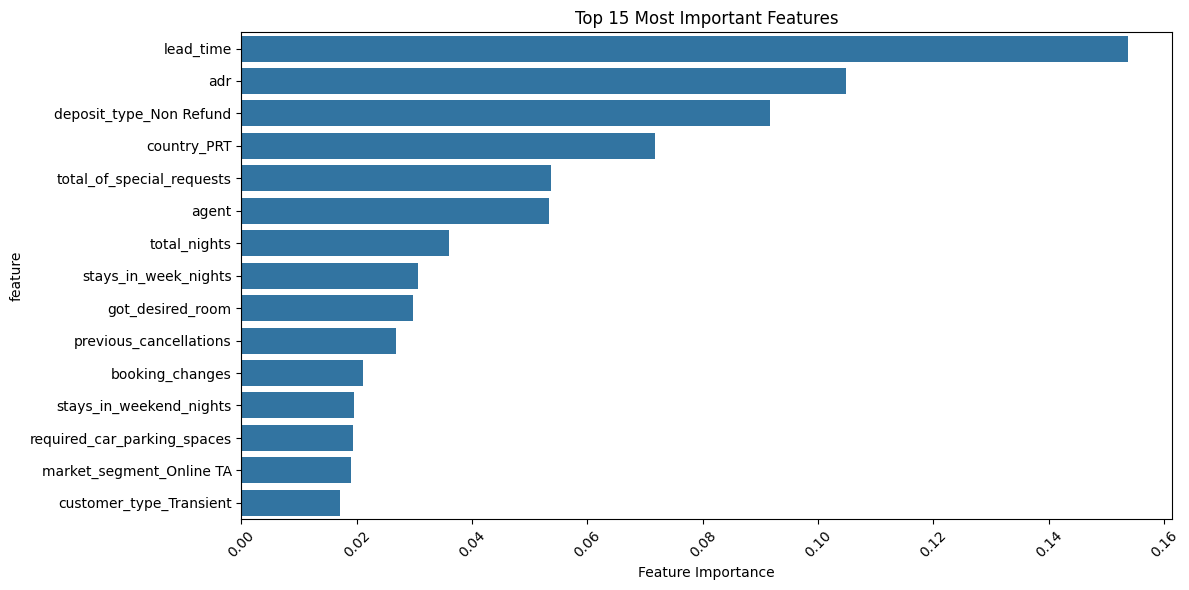


Top 10 Most Important Features:
                       feature  importance
0                    lead_time    0.153665
13                         adr    0.104809
223    deposit_type_Non Refund    0.091730
152                country_PRT    0.071720
15   total_of_special_requests    0.053753
10                       agent    0.053364
16                total_nights    0.035922
2         stays_in_week_nights    0.030539
19            got_desired_room    0.029826
7       previous_cancellations    0.026726


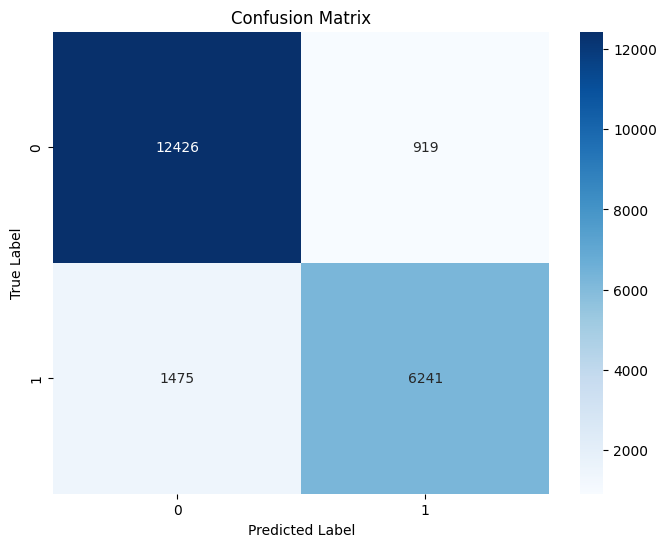


Model Performance Summary:
Total samples in test set: 21061
Correct predictions: 18667
Accuracy: 0.886

Detailed Metrics:
True Negatives (Correctly predicted non-cancellations): 12426
False Positives (Incorrectly predicted cancellations): 919
False Negatives (Missed cancellations): 1475
True Positives (Correctly predicted cancellations): 6241
Precision (Of predicted cancellations, what fraction were actual cancellations): 0.872
Recall (Of actual cancellations, what fraction were caught): 0.809


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Separate features and target
X = df_processed.drop('is_canceled', axis=1)
y = df_processed['is_canceled']

# Split categorical and numerical columns
categorical_features = ['hotel', 'meal', 'country', 'market_segment', 
                       'distribution_channel', 'reserved_room_type',
                       'assigned_room_type', 'deposit_type', 'customer_type']
numerical_features = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
                     'adults', 'children', 'babies', 'is_repeated_guest',
                     'previous_cancellations', 'previous_bookings_not_canceled',
                     'booking_changes', 'agent', 'company', 'days_in_waiting_list',
                     'adr', 'required_car_parking_spaces', 'total_of_special_requests',
                     'total_nights', 'total_guests', 'is_weekend_arrival', 'got_desired_room']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

# Create and train the model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit the model
print("Training model...")
model.fit(X_train, y_train)

# Make predictions
print("\nMaking predictions...")
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Print model performance
print("\nModel Performance:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.3f}")

# Get feature names after one-hot encoding
categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = numerical_features + list(categorical_feature_names)

# Calculate feature importance
feature_importance = model.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features')
plt.xlabel('Feature Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print some additional insights
print("\nModel Performance Summary:")
print(f"Total samples in test set: {len(y_test)}")
print(f"Correct predictions: {(y_pred == y_test).sum()}")
print(f"Accuracy: {(y_pred == y_test).mean():.3f}")

# Calculate class-wise metrics
tn, fp, fn, tp = cm.ravel()
print(f"\nDetailed Metrics:")
print(f"True Negatives (Correctly predicted non-cancellations): {tn}")
print(f"False Positives (Incorrectly predicted cancellations): {fp}")
print(f"False Negatives (Missed cancellations): {fn}")
print(f"True Positives (Correctly predicted cancellations): {tp}")
print(f"Precision (Of predicted cancellations, what fraction were actual cancellations): {tp/(tp+fp):.3f}")
print(f"Recall (Of actual cancellations, what fraction were caught): {tp/(tp+fn):.3f}")

# Modeling

The modeling will be performed using the three datasets: a dataset result of the feature selection done by the filter methods, a dataset result of the Lasso Regularozation and a dataset result of the Random Forest Algorithm.

In [ ]:
# Create the dataset according to the filter methods
df_filter = df_processed_encoded_scaled.drop(columns=['children', 'stays_in_weekend_nights'])
df_filter.head()

,hotel,is_canceled,lead_time,stays_in_week_nights,adults,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,...,assigned_room_type_L,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,season_spring,season_summer,season_winter
0,0.0,0.0,0.919355,0.0,0.036364,0.0,0.0,0.0,0.0,0.176471,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.018817,0.2,0.018182,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.034946,0.2,0.018182,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.037634,0.4,0.036364,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.037634,0.4,0.036364,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
df_lasso = df_processed_encoded_scaled.drop(columns=['adults', 'total_nights', 'country_ATF', 'country_BDI', 'country_BEN',
       'country_BHR', 'country_BHS', 'country_BOL', 'country_BRB',
       'country_CUB', 'country_DMA', 'country_FJI', 'country_FRO',
       'country_IMN', 'country_KHM', 'country_KIR', 'country_LAO',
       'country_MLI', 'country_MRT', 'country_MYT', 'country_NAM',
       'country_NCL', 'country_NIC', 'country_NPL', 'country_PLW',
       'country_PRT', 'country_PRY', 'country_QAT', 'country_SDN',
       'country_SLE', 'country_SLV', 'country_STP', 'country_SUR',
       'country_SYC', 'country_TJK', 'country_TWN', 'country_UMI',
       'country_VGB', 'country_ZMB', 'market_segment_Undefined',
       'distribution_channel_Undefined', 'reserved_room_type_L',
       'assigned_room_type_L'])
df_lasso.head()

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,...,assigned_room_type_K,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,season_spring,season_summer,season_winter
0,0.0,0.0,0.919355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.018817,0.0,0.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.034946,0.0,0.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.037634,0.0,0.4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.037634,0.0,0.4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
df_random_forest = df_processed_encoded_scaled[['lead_time', 'adr', 'deposit_type_Non Refund', 
                                               'country_PRT', 'total_of_special_requests', 'agent', 
                                               'total_nights', 'stays_in_week_nights', 'previous_cancellations', 
                                               'got_desired_room', 'is_canceled']]
df_random_forest.head()

,lead_time,adr,deposit_type_Non Refund,country_PRT,total_of_special_requests,agent,total_nights,stays_in_week_nights,previous_cancellations,got_desired_room,is_canceled
0,0.919355,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0
1,0.018817,0.357381,0.0,0.0,0.0,0.000000,0.111111,0.2,0.0,0.0,0.0
2,0.034946,0.357381,0.0,0.0,0.0,0.568224,0.111111,0.2,0.0,1.0,0.0
3,0.037634,0.466978,0.0,0.0,0.5,0.448598,0.222222,0.4,0.0,1.0,0.0
4,0.037634,0.466978,0.0,0.0,0.5,0.448598,0.222222,0.4,0.0,1.0,0.0


For this particular dataser, since the target variable is slightly imbalanced, the Accuracy might not give the best insights about the models performance, since it can appear high simply by predicting the majority class most of the time, while completely neglecting the minority class.

Precision emphasizes minimizing false positives, which is important when the cost of incorrect positive predictions is high.
Recall focuses on minimizing false negatives, which is critical when it’s more important to capture all positive cases (even at the expense of some false positives).

The F1-score gives us a single metric that balances the trade-off between Precision and Recall. In an imbalanced dataset, this is especially valuable because it ensures that neither the positive nor the negative classes are ignored by the model. F1 is particularly useful when both false positives and false negatives are important to minimize.

For these reasons, the F1-score was chosen as the evaluation metric for the models.


In [ ]:
# Define X and Y for each dataset
X_filter = df_filter.drop('is_canceled', axis=1)
y_filter = df_filter['is_canceled']

X_lasso = df_lasso.drop('is_canceled', axis=1)
y_lasso = df_lasso['is_canceled']

X_random_forest = df_random_forest.drop('is_canceled', axis=1)
y_random_forest = df_random_forest['is_canceled']

## KNN

In [ ]:
# Do grid search for hyperparameter tuning for KNN
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

knn_models = []

# Create the parameter grid
param_grid = {'n_neighbors': [3,5], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan', 'minkowski']}

# Create the model
model = KNeighborsClassifier()

# Create grid search
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='f1_weighted', n_jobs=-1)

# Fit the grid search for each dataset
grid_search.fit(X_filter, y_filter)
print("Best Parameters Filter:")
print(grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)
knn_models.append(('Filter', grid_search.best_estimator_))

grid_search.fit(X_lasso, y_lasso)
print("Best Parameters Lasso:")
print(grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)
knn_models.append(('Lasso', grid_search.best_estimator_))

grid_search.fit(X_random_forest, y_random_forest)
print("Best Parameters Random Forest:")
print(grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)
knn_models.append(('Random Forest', grid_search.best_estimator_))

Best Parameters Filter:
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best Score:  0.8479690491075453
Best Parameters Lasso:
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best Score:  0.8405383897472557
Best Parameters Random Forest:
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best Score:  0.8348998489796816


## Naïve Bayes 

In [ ]:
from sklearn.naive_bayes import GaussianNB
naiveBayes_models = []

# Create the model
gaussianNB = GaussianNB()

## Ensemble Learning

In [ ]:
from sklearn.ensemble import VotingClassifier

# Create the estimators list to store de models of each feature selection method
estimators_filter = []
estimators_lasso = []
estimators_random_forest = []

estimators_filter.append(('KNN', knn_models[0][1]))
estimators_filter.append(('Naive Bayes', gaussianNB))

estimators_lasso.append(('KNN', knn_models[1][1]))
estimators_lasso.append(('Naive Bayes', gaussianNB))

estimators_random_forest.append(('KNN', knn_models[2][1]))
estimators_random_forest.append(('Naive Bayes', gaussianNB))

# Create the ensemble model
ensemble_filter = VotingClassifier(estimators_filter, voting='soft')
ensemble_lasso = VotingClassifier(estimators_lasso, voting='soft')
ensemble_random_forest = VotingClassifier(estimators_random_forest, voting='soft')

## Neural Networks

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.metrics import F1Score

import tensorflow as tf

# Function to create MLP network 

def nnetClassif (inputDim, optimizer, neurons):
       
    # Initialize the Sequential model
    model = Sequential()
    
    model.add(Input(shape=(inputDim,)))
    
    model.add(Dense(units=neurons, 
                    kernel_initializer='uniform', 
                    activation='relu'))    
    
    model.add(Dense(units=neurons, 
                    kernel_initializer='uniform', 
                    activation='relu'))    
    
    model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))  
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[F1Score(average=None, threshold=None, name="f1_score", dtype=None)])
            
    return model


In [ ]:
# Do holdout for grid search for hyperparameter tuning for MLP
from sklearn.model_selection import train_test_split

X_train_filter, X_test_filter, y_train_filter, y_test_filter = train_test_split(X_filter, y_filter, test_size=0.2, random_state=42)
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_lasso, y_lasso, test_size=0.2, random_state=42)
X_train_random_forest, X_test_random_forest, y_train_random_forest, y_test_random_forest = train_test_split(X_random_forest, y_random_forest, test_size=0.2, random_state=42)


In [ ]:
# Creating the classifier ANN
#from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV


#for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

input_dim = X_train_filter.shape[1] 

classifModel = KerasClassifier(model=nnetClassif, inputDim=input_dim, verbose=0)

# hyperparameter grid
Parameter_Trials={'model__optimizer': ['adam','rmsprop'],
                  'model__neurons': [8,16,32],
                  'batch_size': [30,45,60],
                      'epochs': [10,20]
                 }

# Apply GridSearchCV
grid_search = GridSearchCV(estimator=classifModel, param_grid=Parameter_Trials, scoring='f1_weighted', cv=3)
 
import time
StartTime=time.time()
 
# Running Grid Search for different parameters
grid_result = grid_search.fit(X_train_filter, y_train_filter, validation_split=0.1, verbose=-1)

EndTime=time.time()

best_nn_filter = grid_result.best_estimator_.model_


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
E

In [ ]:
input_dim = X_train_lasso.shape[1] 

classifModel = KerasClassifier(model=nnetClassif, inputDim=input_dim, verbose=0)

# hyperparameter grid
Parameter_Trials={'model__optimizer': ['adam','rmsprop'],
                  'model__neurons': [8,16,32],
                  'batch_size': [30,45,60],
                      'epochs': [10,20]
                 }

# Apply GridSearchCV
grid_search = GridSearchCV(estimator=classifModel, param_grid=Parameter_Trials, scoring='f1_weighted', cv=3)
 
import time
StartTime=time.time()
 
# Running Grid Search for different parameters
grid_result = grid_search.fit(X_train_lasso, y_train_lasso, validation_split=0.1, verbose=-1)

EndTime=time.time()
best_nn_lasso = grid_result.best_estimator_.model_

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
E

In [ ]:
input_dim = X_train_random_forest.shape[1] 

classifModel = KerasClassifier(model=nnetClassif, inputDim=input_dim, verbose=0)

# hyperparameter grid
Parameter_Trials={'model__optimizer': ['adam','rmsprop'],
                  'model__neurons': [8,16,32],
                  'batch_size': [30,45,60],
                      'epochs': [10,20]
                 }

# Apply GridSearchCV
grid_search = GridSearchCV(estimator=classifModel, param_grid=Parameter_Trials, scoring='f1_weighted', cv=3)
 
import time
StartTime=time.time()
 
# Running Grid Search for different parameters
grid_result = grid_search.fit(X_train_random_forest, y_train_random_forest, validation_split=0.1, verbose=-1)

EndTime=time.time()
best_nn_random_forest = grid_result.best_estimator_.model_

Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20


c:\Users\tiago\OneDrive\Documentos\uni\mei\.conda\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


# Model Evaluation

The holdout will be the method chosen to perform the evaluation of the methods, since the given dataset is a large one and methods like Cross Validation, Leave One Out and Bootstrap are more suitable for smaller datasets.

## KNN

In [ ]:
# Do holdout validation for the models
from sklearn.model_selection import train_test_split

# Split the data
X_train_filter, X_test_filter, y_train_filter, y_test_filter = train_test_split(X_filter, y_filter, test_size=0.2, random_state=42, stratify=y_filter)
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_lasso, y_lasso, test_size=0.2, random_state=42, stratify=y_lasso)
X_train_random_forest, X_test_random_forest, y_train_random_forest, y_test_random_forest = train_test_split(X_random_forest, y_random_forest, test_size=0.2, random_state=42, stratify=y_random_forest)

# Evaluate the models
from sklearn.metrics import classification_report

for name, model in knn_models:
    if name == 'Filter':
        X_train = X_train_filter
        y_train = y_train_filter
        X_test = X_test_filter
        y_test = y_test_filter
    elif name == 'Lasso':
        X_train = X_train_lasso
        y_train = y_train_lasso
        X_test = X_test_lasso
        y_test = y_test_lasso
    else:
        X_train = X_train_random_forest
        y_train = y_train_random_forest
        X_test = X_test_random_forest
        y_test = y_test_random_forest
        
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name}:")
    print(classification_report(y_test, y_pred))



Filter:
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88     13340
         1.0       0.80      0.78      0.79      7721

    accuracy                           0.85     21061
   macro avg       0.84      0.83      0.83     21061
weighted avg       0.85      0.85      0.85     21061


Lasso:
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87     13340
         1.0       0.78      0.78      0.78      7721

    accuracy                           0.84     21061
   macro avg       0.83      0.83      0.83     21061
weighted avg       0.84      0.84      0.84     21061


Random Forest:
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87     13340
         1.0       0.79      0.76      0.78      7721

    accuracy                           0.84     21061
   macro avg       0.83      0.82      0.82     21061
weighted avg       0.84      0.84      0.

## Naïve Bayes 

## Ensemble Learning

## Neural Networks